<a href="https://colab.research.google.com/github/Okekeprince1/flow-pattern/blob/main/Identification_of_Flow_Bubbles_Final_Year_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=0889f20eb96f9d1f7934dc7e0a8f9e5c30fa379d249edafef4d66059d5023bab
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
# libraries

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
# from torchviz import make_dot


In [4]:
DATA_PATH = "/content/drive/MyDrive/datasets"

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
     transforms.CenterCrop((272, 272)),
     transforms.Resize((64, 64))
     ])

In [6]:
from sklearn.model_selection import train_test_split
dataset = ImageFolder(DATA_PATH)
train_data, test_data, train_label, test_label = train_test_split(dataset.imgs, dataset.targets, test_size=0.2, random_state=42)

# ImageLoader Class

class ImageLoader(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = self.checkChannel(dataset) # some images are CMYK, Grayscale, check only RGB
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        image = Image.open(self.dataset[item][0])
        classCategory = self.dataset[item][1]
        if self.transform:
            image = self.transform(image)
        return image, classCategory


    def checkChannel(self, dataset):
        datasetRGB = []
        for index in range(len(dataset)):
            if (Image.open(dataset[index][0]).getbands() == ("R", "G", "B")): # Check Channels
                datasetRGB.append(dataset[index])
        return datasetRGB

In [7]:
train_dataset = ImageLoader(train_data, transform)
test_dataset = ImageLoader(test_data, transform)

In [8]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [41]:
flow_pattern_class = ["Annular", "Churn", "Slug"]

In [10]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([16, 3, 64, 64])
torch.Size([16])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


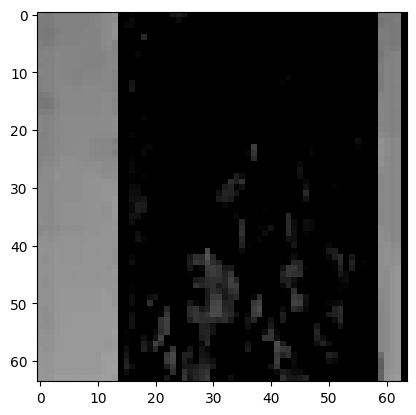

In [11]:
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze().T, cmap='gray_r');

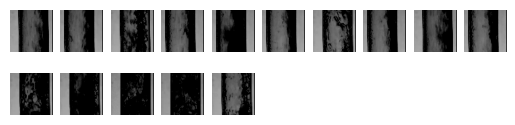

In [12]:
figure = plt.figure()
num_of_images = 15
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze().T, cmap='gray_r')

In [15]:
input_size = 4096 * 3
hidden_sizes = [128, 64]
output_size = 3

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))
print(model)
# make_dot(y.mean(), params=dict(model.named_parameters()))

Sequential(
  (0): Linear(in_features=12288, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
  (5): LogSoftmax(dim=1)
)


In [16]:
criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)
print(images)

#524,288
# 196,608

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

tensor([[ 0.5275,  0.5275,  0.5275,  ..., -0.0065,  0.0208,  0.0391],
        [ 0.5324,  0.5265,  0.5353,  ...,  0.0353,  0.0431,  0.0490],
        [ 0.5373,  0.5422,  0.5422,  ...,  0.0078,  0.0078,  0.0127],
        ...,
        [ 0.5382,  0.5402,  0.5398,  ..., -0.0078, -0.0072,  0.0049],
        [ 0.5373,  0.5373,  0.5373,  ...,  0.0225,  0.0235,  0.0374],
        [ 0.5255,  0.5255,  0.5255,  ...,  0.0539,  0.0549,  0.0656]])


In [17]:
# Loss function and optimizer

import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

In [18]:
from time import time

time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6783924747157741
Epoch 1 - Training loss: 0.408159835415112
Epoch 2 - Training loss: 0.37455868378684326
Epoch 3 - Training loss: 0.2988696646045994
Epoch 4 - Training loss: 0.2625871012742455
Epoch 5 - Training loss: 0.2990469875166545
Epoch 6 - Training loss: 0.3104840423408392
Epoch 7 - Training loss: 0.23800235291993296
Epoch 8 - Training loss: 0.242035660892725
Epoch 9 - Training loss: 0.2273679667630711
Epoch 10 - Training loss: 0.22803119323342233
Epoch 11 - Training loss: 0.1951562441080003
Epoch 12 - Training loss: 0.1961455571691732
Epoch 13 - Training loss: 0.17264717127624396
Epoch 14 - Training loss: 0.18984306097735423

Training Time (in minutes) = 0.9972770174344381


In [19]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 64, 64).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(3), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(3))
    ax2.set_yticklabels(np.arange(3))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

In [20]:
class_s = []
prob_s = []

In [21]:
# images, labels = next(iter(valloader))

# img = images[0].view(1, 64 * 64*3)
# with torch.no_grad():
#     logps = model(img)

# ps = torch.exp(logps)
# probab = list(ps.numpy()[0])
# #add predicted class
# class_s.append(probab.index(max(probab)))
# #add predicted class probability
# prob_s.append(max(probab))
# print("Predicted Flow Pattern =", flow_pattern_class[probab.index(max(probab))])
# newImg = img.view(1, 64 * 64 * 3)
# view_classify(newImg, ps)

In [22]:
correct_count, all_count = 0, 0
for images,labels in valloader:
    for i in range(len(labels)):
        img = images[i].view(1, 64 * 64 * 3)
        with torch.no_grad():
            logps = model(img)


        ps = torch.exp(logps)
        probab = list(ps.numpy()[0])
        pred_label = probab.index(max(probab))
        true_label = labels.numpy()[i]
        if(true_label == pred_label):
            correct_count += 1
        all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 146

Model Accuracy = 0.8835616438356164


In [23]:
# Save the trained model

PATH = './flow_patterns_net.pth'
torch.save(model, PATH)

Code for Chart Generation

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [25]:
# Using Air and Water
# Atmospheric conditions
T = (273+20)
R = 0.082
P = 1 # Pressure laboratory [bar]
# Properties of the fluids
M = 28.96 # Molecular mass air [g/mol]
rog= ((P*M)/(R*T)) # Density of air [g/dm^3]=[kg/m^3]
rol = 1000 # Density of water [g/dm^3]=[kg/m^3]
mut = 1*10**-3 # Viscosity of water [Poise]
vl= 1.004e-6
mug = 1.83*10**-5 #Viscosity of air [Poise]
# Geometry
pi = np.math.pi
Dg = 0.021 # Pipe diameter [m]
A = pi/4 # Section of the pipe [m^2]
# Martinelli Parameter
n = 0.2
C = 0.046
F_R = np.sqrt((rog/(rol-rog))/(Dg*9.81))
s=0.01 # Sheltering coefficient [0.01-0.03]
g=9.81 # Standard gravity [m/s^2]

In [26]:
# # Using R134a and Water
# # Atmospheric conditions
# T = (273+40) #Tsat
# R = 0.082
# P = 1.1467*10**3 # Pressure laboratory [bar]
# # Properties of the fluids
# M = 1.6145*10**-4 # Molecular mass R134a [g/mol]
# rog= ((P*M)/(R*T)) # Density of R134a [g/dm^3]=[kg/m^3]
# rol = 1000 # Density of water [g/dm^3]=[kg/m^3]
# mut = 1*10**-3 # Viscosity of water [Poise]
# vl= 1.004e-6
# mug = 1.5*10**-4 #Viscosity of R134a [Poise]
# # Geometry
# pi = np.math.pi
# Dg = 0.021 # Pipe diameter [m]
# A = pi/4 # Section of the pipe [m^2]
# # Martinelli Parameter
# n = 0.2
# C = 0.046
# F_R = np.sqrt((rog/(rol-rog))/(Dg*9.81))
# s=0.01 # Sheltering coefficient [0.01-0.03]
# g=9.81 # Standard gravity [m/s^2]

In [27]:
def geenerate_plot_points(plot_type='A'):
    Wa = None                    # Mass flow rate of air [kg/s]
    Ww = None                    # Mass flow rate of water [kg/s]
    if plot_type=='A':
        Wa = np.arange(0.0001,0.1,0.001)
        Ww = np.arange(0.001,10,0.01)
    elif plot_type == 'D':
        Wa=np.arange(0.00001,0.7,0.01)
        Ww=np.arange(0.001,10,0.1)
    elif plot_type == 'C':
        Wa=np.arange(0.000001,0.01,0.0001)
        Ww=np.arange(0.001,2,0.01)
    else:
        F = np.arange(0.1,10)
        return (0*F + 1.6, F)

    K=1

    x = np.zeros((len(Wa),len(Ww)))
    Xtt = np.zeros((len(Wa),len(Ww)))
    hld = np.zeros((len(Wa),len(Ww)))
    C2 = np.zeros((len(Wa),len(Ww)))
    Al = np.zeros((len(Wa),len(Ww)))
    Ag = np.zeros((len(Wa),len(Ww)))
    Ull = np.zeros((len(Wa),len(Ww)))
    Ugg = np.zeros((len(Wa),len(Ww)))
    F = np.zeros((len(Wa),len(Ww)))
    FF = np.zeros((len(Wa),len(Ww)))
    F2 = np.zeros((len(Wa),len(Ww)))
    Sll = np.zeros((len(Wa),len(Ww)))
    Dll = np.zeros((len(Wa),len(Ww)))
    Sii = np.zeros((len(Wa),len(Ww)))
    T = np.zeros((len(Wa),len(Ww)))
    T2 = np.zeros((len(Wa),len(Ww)))
    KK = np.zeros((len(Wa),len(Ww)))

    ULs = np.zeros(len(Ww))
    Nom = np.zeros(len(Ww))

    UGs = np.zeros(len(Wa))
    Den = np.zeros(len(Wa))

    f =[]
    xtt = []


    for i in range(len(Wa)):
        for j in range(len(Ww)):
            x[i,j] =Wa[i]/(Ww[j]+Wa[i]) # Flow quality

            ULs[j] = Ww[j]/(pi*Dg**2/4)/rol
            UGs[i] = Wa[i]/(pi*Dg**2/4)/rog
            Nom[j] = ((ULs[j]*Dg/(mut/rol))**(-n)*rol*ULs[j]**2/2)
            Den[i] = ((UGs[i]*Dg/(mug/rog))**(-n)*rog*UGs[i]**2/2)

            Xtt[i,j] = (Nom[j]/Den[i])**0.5

            if Xtt[i,j] <= 10**-2:
                hld[i,j] = 0.1
            elif Xtt[i,j]>10**-2 and Xtt[i,j]<1:
                hld[i,j] = 0.0536*np.log(Xtt[i,j])+0.321
            elif Xtt[i,j]>1 and Xtt[i,j]<=10:
                hld[i,j] = 0.1513*np.log(Xtt[i,j])+0.4869
            elif Xtt[i,j]>10 and Xtt[i,j]< 1000:
                hld[i,j] = 0.0402*np.log(Xtt[i,j])+0.73
            elif Xtt[i,j]>= 1000:
                hld[i,j]=0.99


            C2[i,j] = 1-hld[i,j]
            Al[i,j] = 0.25*(pi-(np.arccos(2*hld[i,j]-1)) + (2*hld[i,j]-1)*np.sqrt(1-(2*hld[i,j]-1)**2))
            Ag[i,j] = 0.25*(np.arccos(2*hld[i,j]-1)-(2*hld[i,j]-1)*np.sqrt(1-(2*hld[i,j]-1)**2))
            Ull[i,j] = A/Al[i,j]
            Ugg[i,j] = A/Ag[i,j]

            if plot_type == 'A':
                F[i,j] = F_R*UGs[i]
                FF[i,j] = (Ugg[i,0]*(np.sqrt(1-(2*hld[i,j]-1)**2))/((C2[i,j]**2)*Ag[i,j]))
                F2[i,j] = F[i,j]**2*FF[i,j]

                if F2[i,j] >=0.6 and F2[i,j]<=1:
                    f.append(F[i,j])
                    xtt.append(Xtt[i,j])
                    K+=1
            elif plot_type == 'D':
                Sll[i,j]= pi-np.arccos(2*hld[i,j]-1)
                Dll[i,j]= 4*Al[i,j]/Sll[i,j]
                Sii[i,j] = np.sqrt(1-(2*hld[i,j]-1)**2)
                T[i,j]= np.sqrt(((4*C/Dg)*(ULs[j]*Dg/vl)**(-n)*(rol*(ULs[j]**2))/2)/((rol-rog)*9.81))
                T2[i,j] = T[i,j]**2

                if T2[i,j]>= ((8*Ag[i,j])/((Sii[i,j]*Ull[i,j]**2*(Ull[i,j]*Dll[i,j])**(-n)))-0.2) and T2[i,j]<=(((8*Ag[i,j])/((Sii[i,j]*Ull[i,j]**2*(Ull[i,j]*Dll[i,j])**(-n))))+0.2) and Xtt[i,j]>= 1.6:
                    f.append(T[i,j])
                    xtt.append(Xtt[i,j])
                    K+=1
            else:
                KK[i,j]=np.sqrt((rog*(UGs[i]**2))*(ULs[j]/vl)/((rol-rog)*9.81))

                if KK[i,j]<= 2/(np.sqrt(Ull[i,j])*Ugg[i,j]*np.sqrt(s)) and KK[i,j]>= (2/(np.sqrt(Ull[i,j])*Ugg[i,j]*np.sqrt(s))-0.5):
                    f.append(KK[i,j])
                    xtt.append(Xtt[i,j])
                    K+=1

    return (xtt,f)

In [28]:
xttA,fA = geenerate_plot_points('A')
xttB,fB = geenerate_plot_points('B')
xttC,fC = geenerate_plot_points('C')
xttD,fD = geenerate_plot_points('D')

In [29]:
def pick_point_prob(center,xscale,yscale,p=.99):
    point = (np.random.normal(loc=center[0],scale=xscale*(1-p)),np.random.normal(loc=center[1],scale=yscale*(1-p)))
    return [10**p for p in point]

def get_postion(pred,prob):
    if pred == 0:
        xscale,yscale=.5,.14
        center = (-1.4,0.5)
    elif pred == 1:
        xscale,yscale=.6,.14
        center = (2.1,0.5)
    elif pred == 2:
        xscale,yscale=.5,.14
        center = (0,-1.5)
    elif pred == 3:
        xscale,yscale=.8,.12
        center = (-0.1,-2.6)
    else:
        xscale,yscale=.8,.12
        center = (-0.1,-2.6)


    return pick_point_prob(center,xscale,yscale,p=prob)

In [30]:
def make_plot():#class_s,prob_s):
    global class_s,prob_s

#     plt.figure(figsize=(30,18))
    fig, ax1 = plt.subplots()

    fig.set_size_inches(18.5, 10.5)
    fig.set_dpi(100)

    ax1.plot(xttA,fA)
    ax1.plot(xttB,fB)
    ax1.plot(xttD,fD)

    ax1.set_xlabel('Xtt')
    ax1.set_ylabel('Y1:T or F, Y2:K')
    ax1.set_title('Construction of Yemada Taitel and A.E. Dukler flow pattern map')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlim([0.001,10000])
    ax1.set_ylim([0.001,10])

    ax2 = ax1.twinx()
    ax2.plot(xttC,fC,'r')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_ylim([1, 10000])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend(['A','B','D','C'])

    markers = ['*', 'x', '+', 'o']
    colors = ['b','r','g','k']

    for ix,i in enumerate(class_s):
        point = get_postion(class_s[ix],prob_s[ix])
        ax1.scatter([point[0]],[point[1]],marker=markers[class_s[ix]],c=colors[class_s[ix]])

    plt.savefig('full_image.pdf')
    plt.savefig('full_image.png')
    plt.show()

Draw chart and Identify position of predicted flow on chart

Predicted Flow Pattern = Slug



classes preficted [0, 1, 1, 4, 4, 4, 0, 0, 0, 1, 2] [0.9806872, 0.9998394, 0.99837106, 984642, 984642, 984642, 0.84785306, 0.9038857, 0.60292184, 0.935621, 0.96284944]


ValueError: ignored

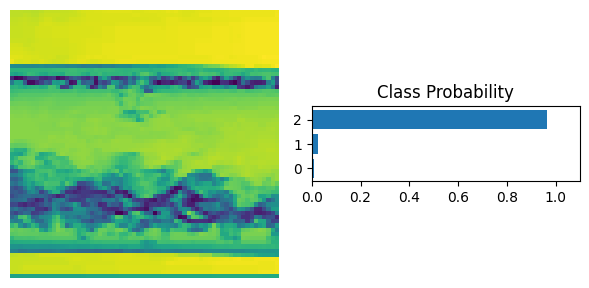

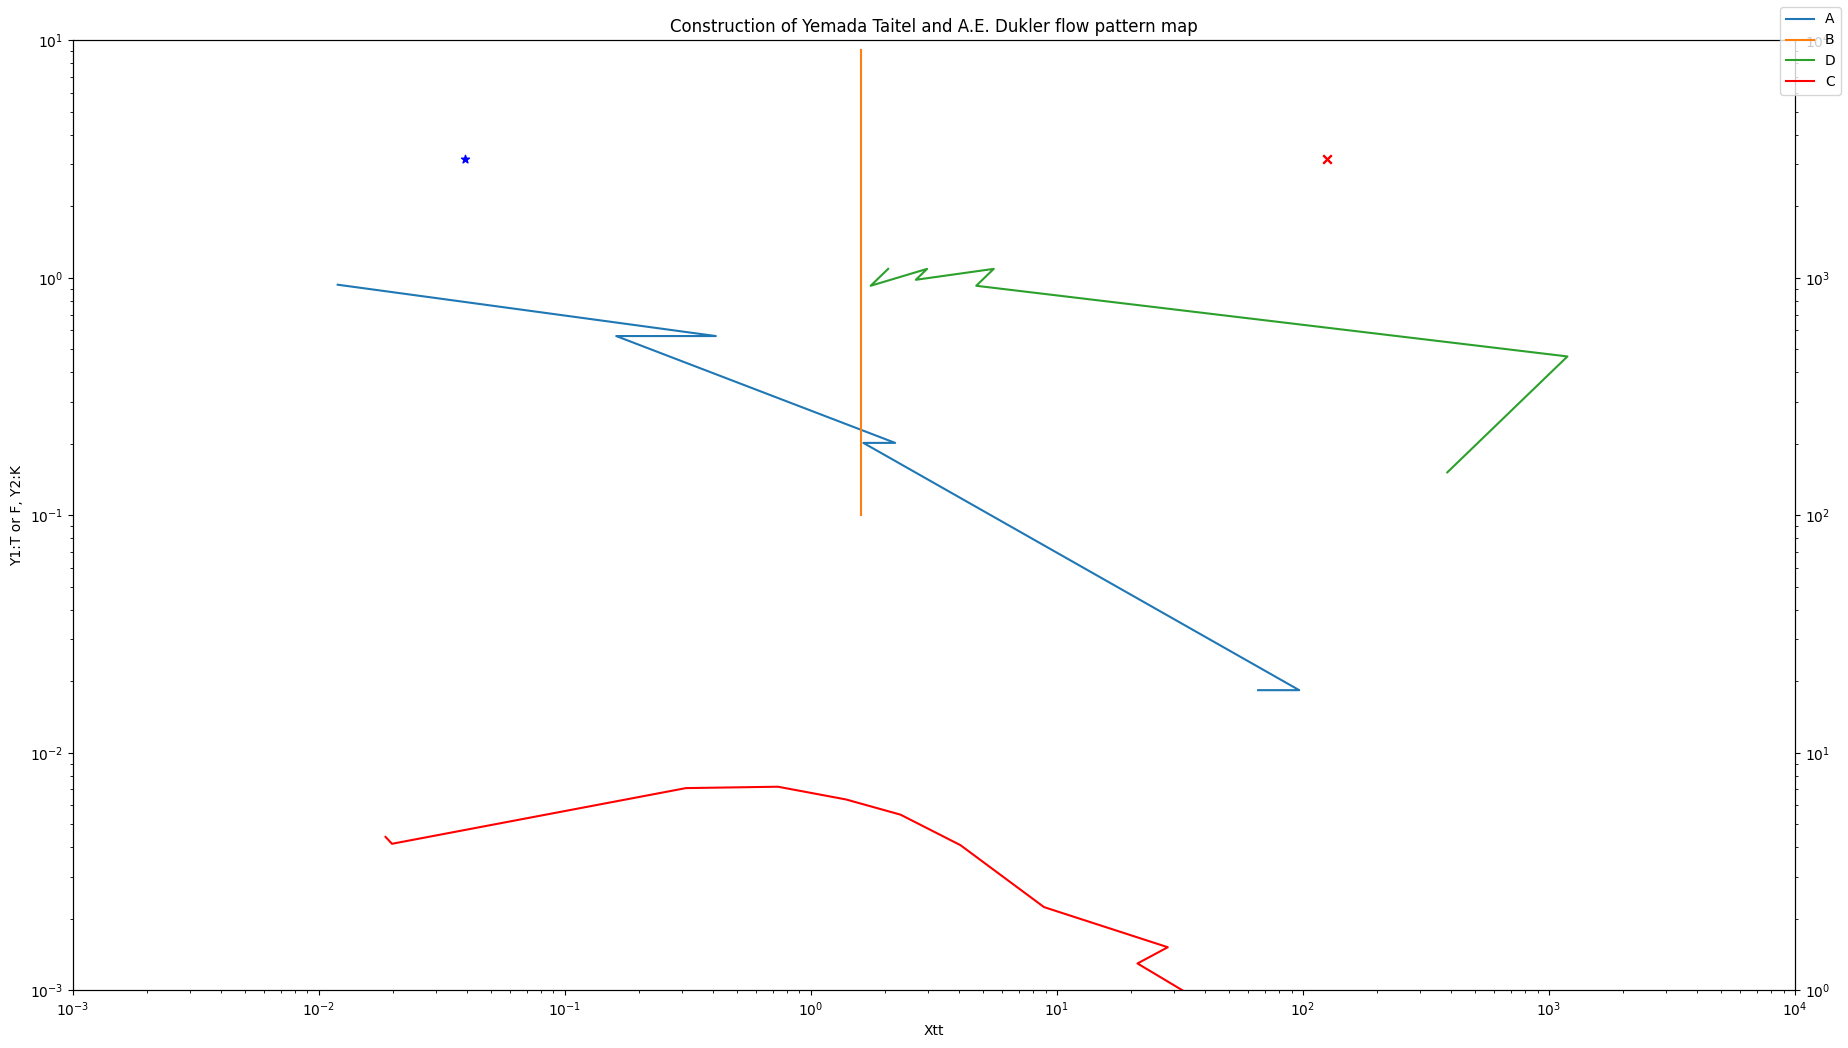

In [45]:
images, labels = next(iter(valloader))

img = images[0].view(1, 64 * 64*3)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
#add predicted class
class_s.append(probab.index(max(probab)))
#add predicted class probability
prob_s.append(max(probab))
print("Predicted Flow Pattern =", flow_pattern_class[probab.index(max(probab))])
newImg = img.view(1, 64 * 64 * 3)
view_classify(newImg, ps)
print("\n\n")
print("classes preficted", class_s, prob_s)
make_plot()